## Importation des packages

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import *
from statsmodels.stats.diagnostic import acorr_ljungbox
import seaborn as sns
import scipy.stats as stats
from sklearn.cluster import KMeans
from sklearn import decomposition
from sklearn import preprocessing
import scipy.stats as st
from collections import Counter
from datetime import datetime as dt 
from statsmodels.tsa.api import ExponentialSmoothing
from scipy.stats import t, shapiro
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm   

## Importation des données

 on télécharge un fichier de type csv qui contient les indicateurs du marché électrique mensuel de plusieurs régions sur une période de 9 ans 

In [1]:
df = pd.DataFrame(pd.read_csv("data_projet9.csv",index_col="Mois"))
df

NameError: name 'pd' is not defined

on laisse ce que nous s’intéresse la consommation électrique en france

In [3]:
df=df[['Territoire','Consommation totale']]
df

,Territoire,Consommation totale
Mois,,
2012-01,France,51086
2012-02,France,54476
2012-03,France,43156
2012-04,France,40176
2012-05,France,35257
...,...,...
2021-07,Occitanie,2766
2021-07,Normandie,1830
2021-07,Hauts-de-France,3500


In [4]:
df_fr=df[df['Territoire']=='France']
df_fr.drop(columns='Territoire', inplace=True)

C:\Users\BOULANGER\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


on utilise le package pandas profiling qui nous donne un rapport très utile pour analyser notre dataset

In [5]:
from pandas_profiling import ProfileReport
profile  =  ProfileReport ( df_fr , explorative=True )
profile

Summarize dataset:   0%|          | 0/16 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

 y’a pas de valeurs manquante ni des lignes doublons on a un historique de  115 observation représentant la consommation mensuelle de l’énergie électrique en france

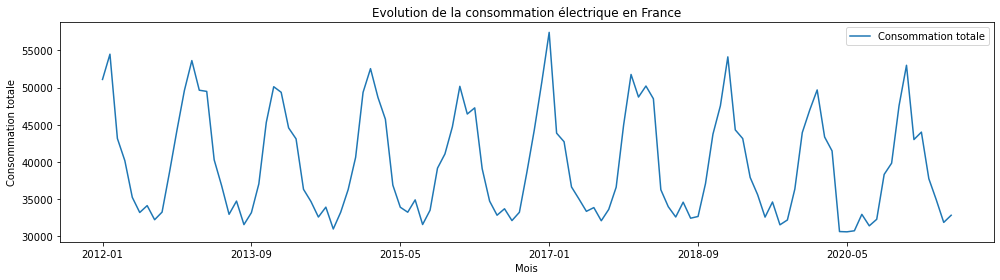

In [6]:
df_fr.plot(y="Consommation totale", figsize=(14,4))
plt.title('Evolution de la consommation électrique en France')
plt.ylabel('Consommation totale') 
plt.tight_layout()
# Sauvegarde
plt.savefig("Evolution de la consommation électrique en France.png",dpi=80, format='png', bbox_inches="tight")
plt.show()

 on veux corriger notre série de l’effet de température donc on télécharge des différents fichiers de type excel qui contient le dju mensuel de plusieur région

In [7]:
ville=['amberieu.xlsx','st_quentin.xlsx','vichy.xlsx','st_auban.xlsx','embrun.xlsx','cannes.xlsx','nice.xlsx',
              'lanas.xlsx','charleville.xlsx','st_girons.xlsx','troyes.xlsx','carcassonne.xlsx','millau.xlsx','provence.xlsx',
              'marseille.xlsx','caen.xlsx','aurillac.xlsx','cognac.xlsx','rochelle.xlsx','bourges.xlsx','brive.xlsx',
              'dijon.xlsx','st_brieuc.xlsx','gueret.xlsx','bergerac.xlsx','besancon.xlsx','montelimar.xlsx','evreux.xlsx',
              'chartres.xlsx','brest.xlsx','nimes.xlsx','toulouse.xlsx','auch.xlsx','bordeaux.xlsx','lege.xlsx',
              'montpellier.xlsx','rennes.xlsx','chateauroux.xlsx','tours.xlsx','grenoble.xlsx','lons.xlsx','dax.xlsx',
              'blois.xlsx','st_etienne.xlsx','puy.xlsx','nante.xlsx','amilly.xlsx','orleans.xlsx','gourdon.xlsx','agen.xlsx',
              'mende.xlsx','cholet.xlsx','pte.xlsx','reim_ch.xlsx','st_dizier.xlsx','laval.xlsx','vassincourt.xlsx',
              'vannes.xlsx','nevers.xlsx','lille.xlsx','beauvais.xlsx','alencon.xlsx','touquet.xlsx','clermont.xlsx',
              'biarritz.xlsx','pau.xlsx','tarbes.xlsx','perpignan.xlsx','lyon.xlsx','luxeuil.xlsx','macon.xlsx','mans.xlsx',
              'chambery.xlsx','val.xlsx','evian.xlsx','paris.xlsx','dieppe.xlsx','rouen.xlsx','melun.xlsx','villacoublay.xlsx',
              'niort.xlsx','abbeville.xlsx','amiens.xlsx','albi.xlsx','montauban.xlsx','hyeres.xlsx','avignon.xlsx',
              'orange.xlsx','ile.xlsx','roche.xlsx','poitiers.xlsx','limoges.xlsx','epinal.xlsx','auxerre.xlsx','orly.xlsx',
              'roissy.xlsx','metz_ch.xlsx','mulh_ch.xlsx','nancy_ch.xlsx','stra_ch.xlsx']

 on crée un dataframe des données DJU mensuel de chaque région

In [8]:
df_dju_fr = pd.DataFrame()
for i in ville:
    ii = i
    df_ville = pd.read_excel(ii,skiprows=10,header=1, converters={'Unnamed: 0':str})
    ville = i.split('.')[0]
    df_ville["Ville"] = ville
    df_dju_fr = pd.concat([df_dju_fr,df_ville], ignore_index=True)

C:\Users\BOULANGER\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:221: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [9]:
df_dju_fr .drop(columns='Total', inplace=True)

In [10]:
df_dju_fr.rename(columns = {
    'Unnamed: 0' : 'année',
    'JAN':'01','FÉV':'02','MAR':'03','AVR':'04','MAI':'05','JUN':'06','JUI':'07','AOÛ':'08','SEP':'09','OCT':'10','NOV':'11',
    'DÉC':'12'
}, inplace = True)
df_dju_fr 

,année,01,02,03,04,05,06,07,08,09,10,11,12,Ville
0,2021,493.1,293.9,328.4,259.1,165.7,4.4,0.0,0.0,0.0,0.0,0.0,0.0,amberieu
1,2020,422.4,304.9,312.7,133.0,94.0,43.5,1.8,7.5,54.3,204.1,292.8,409.9,amberieu
2,2019,490.0,335.2,285.1,213.0,169.3,27.3,0.3,11.5,53.7,131.1,334.2,372.1,amberieu
3,2018,323.7,448.8,324.1,115.8,66.9,6.4,0.1,5.3,27.0,170.8,301.4,388.6,amberieu
4,2017,583.7,293.7,232.5,221.8,92.7,9.8,2.4,8.4,83.0,138.6,360.3,441.4,amberieu
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,2013,489.4,472.3,439.2,208.7,151.4,35.5,0.0,6.8,64.9,157.3,362.5,440.5,stra_ch
1296,2012,429.8,544.7,262.7,226.8,66.7,21.7,8.7,2.0,69.6,231.6,330.6,420.1,stra_ch
1297,2011,474.2,386.3,299.6,113.1,57.4,27.0,31.1,15.9,36.9,223.5,362.4,379.8,stra_ch
1298,2010,582.7,426.8,351.7,200.8,159.2,24.5,3.0,18.8,98.5,250.8,328.8,588.6,stra_ch


In [11]:
ii=df_dju_fr .melt(id_vars=['Ville','année'])
ii.rename(columns = {'value' : 'DJU'}, inplace = True)
ii

,Ville,année,variable,DJU
0,amberieu,2021,01,493.1
1,amberieu,2020,01,422.4
2,amberieu,2019,01,490.0
3,amberieu,2018,01,323.7
4,amberieu,2017,01,583.7
...,...,...,...,...
15595,stra_ch,2013,12,440.5
15596,stra_ch,2012,12,420.1
15597,stra_ch,2011,12,379.8
15598,stra_ch,2010,12,588.6


In [12]:
ii['Mois'] = ii['année'].astype(str)+'-'+ii['variable'].astype(str)
ii

,Ville,année,variable,DJU,Mois
0,amberieu,2021,01,493.1,2021-01
1,amberieu,2020,01,422.4,2020-01
2,amberieu,2019,01,490.0,2019-01
3,amberieu,2018,01,323.7,2018-01
4,amberieu,2017,01,583.7,2017-01
...,...,...,...,...,...
15595,stra_ch,2013,12,440.5,2013-12
15596,stra_ch,2012,12,420.1,2012-12
15597,stra_ch,2011,12,379.8,2011-12
15598,stra_ch,2010,12,588.6,2010-12


on groupe les données par moyenne pour obtenir les données dju de la france

In [13]:
dj_moy= ii.groupby(by='Mois').mean()
dj_moy.drop( dj_moy[ dj_moy['DJU'] == 0 ].index, inplace=True)


In [14]:
dj_moy.head(152)#la valeur représentative de l’écart entre la température d’une journée donnée et un seuil de température(18)

,DJU
Mois,
2009-01,455.685
2009-02,355.771
2009-03,299.834
2009-04,176.666
2009-05,81.547
...,...
2021-02,286.461
2021-03,299.591
2021-04,248.450


on fait la jointure avec notre base de données


In [15]:
df_fr = df_fr.merge(dj_moy, how='inner', left_index=True, right_index=True)
df_fr.rename(columns = {'Consommation totale' : 'Consommation'}, inplace = True)
df_fr.head(10)

,Consommation,DJU
Mois,,
2012-01,51086,367.131
2012-02,54476,470.600
2012-03,43156,241.254
2012-04,40176,233.710
2012-05,35257,101.300
2012-06,33219,40.365
2012-07,34141,23.801
2012-08,32247,7.892
2012-09,33269,65.562


on compare entre l’évolution de la consommation et dju en france

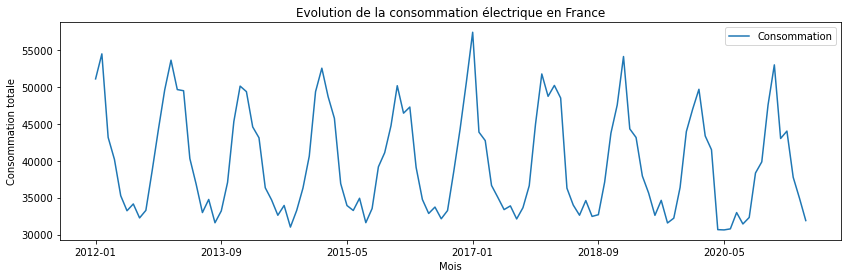

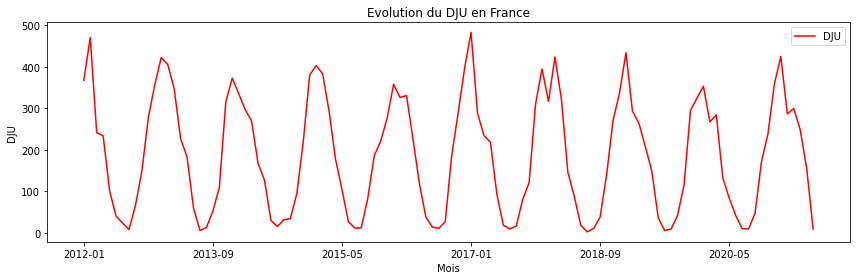

In [86]:
df_fr.plot(y="Consommation", figsize=(14,4))
plt.title('Evolution de la consommation électrique en France')
plt.ylabel('Consommation totale') 
df_fr.plot(y="DJU", color='r', figsize=(12,4))
plt.legend()
plt.title('Evolution du DJU en France')
plt.ylabel('DJU') 
plt.tight_layout()
# Sauvegarde
plt.savefig("Evolution de la consommation et du dju.png",dpi=80, format='png', bbox_inches="tight")
plt.show()

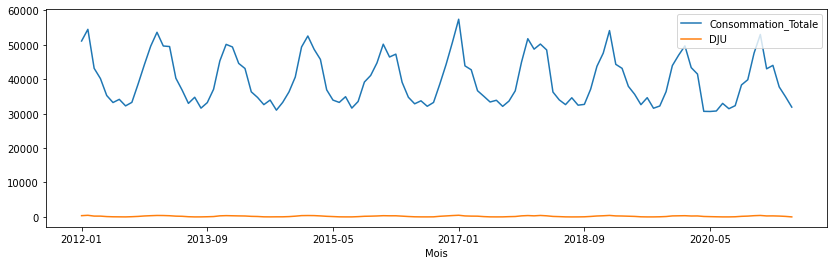

In [17]:
df_fr['Consommation'].plot(figsize=(14,4),label="Consommation_Totale")
df_fr['DJU'].plot(figsize=(14,4),label="DJU")
plt.legend()

### Correction des données de consommation mensuelles de l'effet température à l'aide de la régression linéaire

On effectue la régression linéaire sur notre série

In [18]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
reg1 = smf.ols("Consommation ~ DJU", data=df_fr).fit(alpha=0.05)
print(reg1.summary())

                            OLS Regression Results                            
Dep. Variable:           Consommation   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     1509.
Date:                Mon, 25 Oct 2021   Prob (F-statistic):           7.84e-67
Time:                        00:04:56   Log-Likelihood:                -1019.6
No. Observations:                 114   AIC:                             2043.
Df Residuals:                     112   BIC:                             2049.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.072e+04    291.836    105.266      0.0

pour évaluer notre modèle on teste la normalité des résidus dans un premier temps  on utilise le test de shapiro wilk

In [19]:
shapiro(reg1.resid)

ShapiroResult(statistic=0.9779303073883057, pvalue=0.056363508105278015)

on trace la droite de henry pour rassurer la normalité des résidus

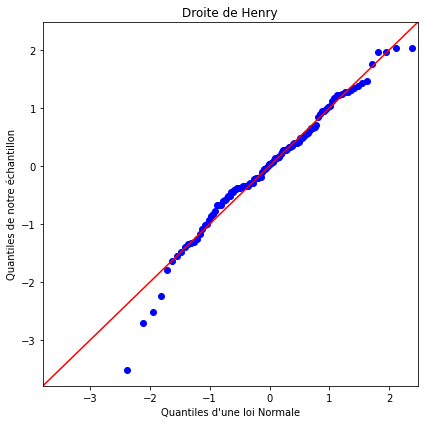

In [20]:
fig, ax = plt.subplots(figsize=(6,6))
sm.qqplot(reg1.resid,line='45', fit=True,ax=ax)# la distribution des erreurs est compatible avec la loi normale (on accepte l'hypothèse de la normalité)
plt.ylabel('Quantiles de notre échantillon', fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Quantiles d\'une loi Normale',fontsize=10)
plt.xticks(fontsize=10)
plt.title('Droite de Henry', fontsize=12)
plt.tight_layout()
plt.savefig('Droite de Henry.png')

On retire l'effet de la température de la consommation:

In [21]:
serie= df_fr['Consommation'] - df_fr['DJU']*reg1.params[1]

On trace le graphique pour voir la différence entre la série initiale et la série corrigée des effets de température 

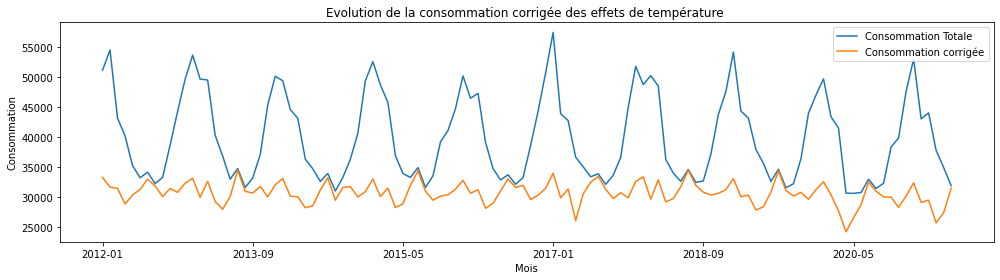

In [22]:
df_fr['Consommation'].plot(figsize=(14,4),label="Consommation Totale",legend = True)
serie.plot(legend = True,label="Consommation corrigée")
plt.title('Evolution de la consommation corrigée des effets de température ')
plt.ylabel('Consommation') 
plt.tight_layout()
# Sauvegarde
plt.savefig("Evolution de la consommation corrigée des effets de température.png",dpi=80, format='png', bbox_inches="tight")
plt.show()

on remarque qu’il ya une forte saisonnalité sur la série corrigée

### Désaisonnalisation de la consommation grâce aux moyennes mobiles

In [23]:
df_cor = pd.DataFrame({ 'Mois':serie.index,'serie_corrigée':serie.values})
df_cor.set_index(['Mois'], inplace = True)
df_cor.index=pd.to_datetime(df_cor.index)
df_cor

,serie_corrigée
Mois,
2012-01-01,33281.381723
2012-02-01,31653.483347
2012-03-01,31455.992706
2012-04-01,28841.851324
2012-05-01,30344.290827
...,...
2021-02-01,29119.605306
2021-03-01,29482.844483
2021-04-01,25709.010917


In [24]:
log_serie = np.log(serie)

avec la fonction seasonal decompose on peut décomposer notre série par contre on prend le logarithme de notre série pour qu'on soit sûr que le modèle est de type additif 

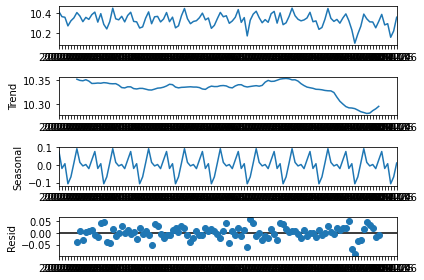

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
decomp_x = seasonal_decompose(log_serie,model='additive',period=12)
decomp_x.plot()
plt.show()

on retranche la saisonnalité et voilà la série corrigée de l’effet de température et désaisonnalisée

In [26]:
df_cor['série_désaisonnalisée']=np.exp(log_serie.values-decomp_x.seasonal.values)

In [27]:
df_cor

,serie_corrigée,série_désaisonnalisée
Mois,,
2012-01-01,33281.381723,30885.134116
2012-02-01,31653.483347,32314.481199
2012-03-01,31455.992706,31262.767168
2012-04-01,28841.851324,32091.930943
2012-05-01,30344.290827,32481.726466
...,...,...
2021-02-01,29119.605306,29727.689931
2021-03-01,29482.844483,29301.739453
2021-04-01,25709.010917,28606.062547


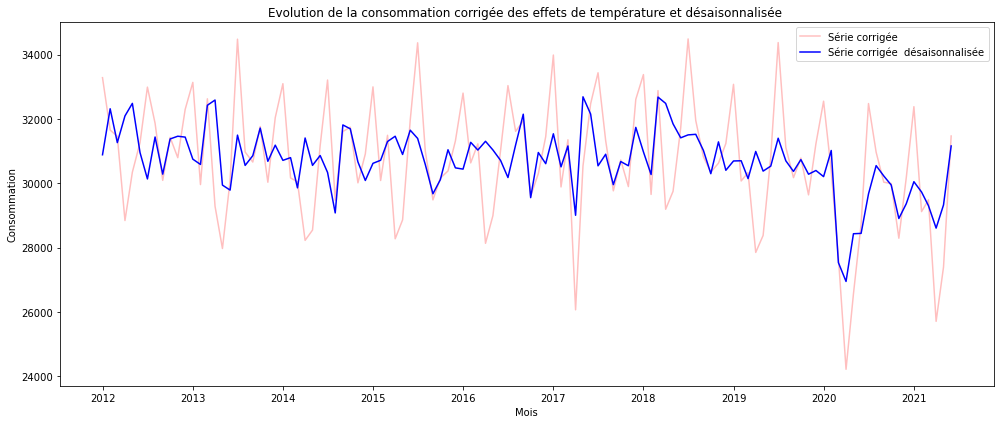

In [28]:
plt.figure(figsize=(14,6))
plt.plot(df_cor["serie_corrigée"],'r', label="Série corrigée",alpha=0.25)
plt.plot(df_cor["série_désaisonnalisée"],'b', label="Série corrigée  désaisonnalisée")
plt.legend()
plt.title('Evolution de la consommation corrigée des effets de température et désaisonnalisée ')
plt.ylabel('Consommation') 
plt.xlabel('Mois') 
plt.tight_layout()
# Sauvegarde
plt.savefig("Evolution de la consommation corrigée des effets de température et désaisonnalisée .png",dpi=80, format='png', bbox_inches="tight")
plt.show()

Afin atteindre notre objectif,  on procède à deux classes des modèles de prévision.


### Prévision avec la méthode de holt winters

In [29]:
log_serie.index=pd.to_datetime(log_serie.index)
serie.index=pd.to_datetime(serie.index)

avant d’appliquer cette méthode on divise notre base de données en deux partie on prend les données de 12 dernier mois comme données test pour évaluer la performance de notre modèle et le reste de données pour entraîner le modèle 

In [30]:
log_train=log_serie[:-12]
train=serie[:-12]
x_a_prevoir=serie.tail(12)

on utilise la fonction exponential smoothing de statmodel on a comme paramètre notre série en logarithme donc le type de  modèle est  additif  et on prend la période de saisonnalité de 12 mois


In [31]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
log_hw = ExponentialSmoothing(np.asarray(log_train), seasonal_periods=12, trend='add', seasonal='add',damped_trend=True).fit()
log_hw_pred = log_hw.forecast(12)
hw_pred=np.exp(log_hw_pred)

C:\Users\BOULANGER\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


on fait une prévision sur les 12 dernier  mois 

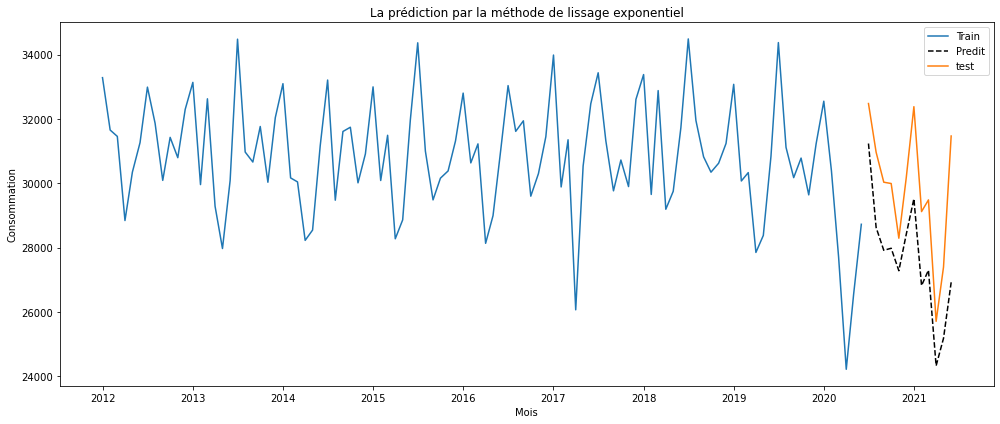

In [32]:
plt.figure(figsize=(14,6))
plt.plot(train.index,train.values, label='Train')
plt.plot(pd.date_range(train.index[len(train)-1], periods=12, freq='M'), hw_pred,'--',color='k', label='Predit')
plt.plot(pd.date_range(train.index[len(train)-1], periods=12, freq='M'), x_a_prevoir, label='test')
plt.legend()
plt.title('La prédiction par la méthode de lissage exponentiel')
plt.ylabel('Consommation') 
plt.xlabel('Mois') 
plt.tight_layout()
# Sauvegarde
plt.savefig("La prédiction par la méthode de lissage exponentiel.png",dpi=80, format='png', bbox_inches="tight")
plt.show()

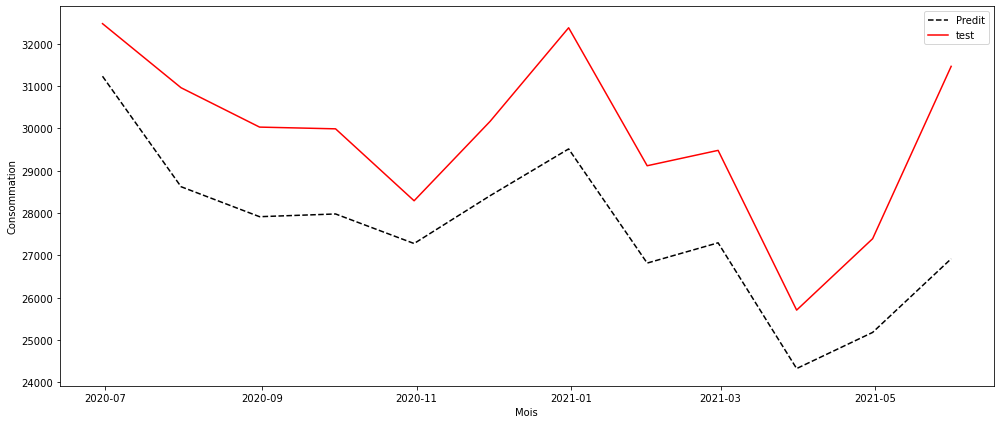

In [33]:
plt.figure(figsize=(14,6))
plt.plot(pd.date_range(train.index[len(train)-1], periods=12, freq='M'), hw_pred,'--',color='k', label='Predit')
plt.plot(pd.date_range(train.index[len(train)-1], periods=12, freq='M'), x_a_prevoir,color='r', label='test')
plt.legend()
plt.ylabel('Consommation') 
plt.xlabel('Mois') 
plt.tight_layout()
# Sauvegarde
plt.savefig("La prédiction holt_winters.png",dpi=80, format='png', bbox_inches="tight")

pour évaluer la performance de ce modèle on a calculé deux métriques l’erreur absolue moyenne en pourcentage et l’erreur quadratique moyenne.

L’erreur absolue moyenne en pourcentage

In [34]:
mape=(np.abs(1-hw_pred/x_a_prevoir)).mean()*100 
mape

7.213929368571172

L’erreur quadratique moyenne

In [35]:
rmse = np.sqrt(((x_a_prevoir-hw_pred)**2).mean())
rmse

2333.9539311101735

## Prévision avec la méthode SARIMA

la série doit être stationnaire c’est à dire que ses caractéristiques (moyenne et variance) doivent être stables dans le temps.

### Stationnarisation de la série

C:\Users\BOULANGER\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
C:\Users\BOULANGER\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


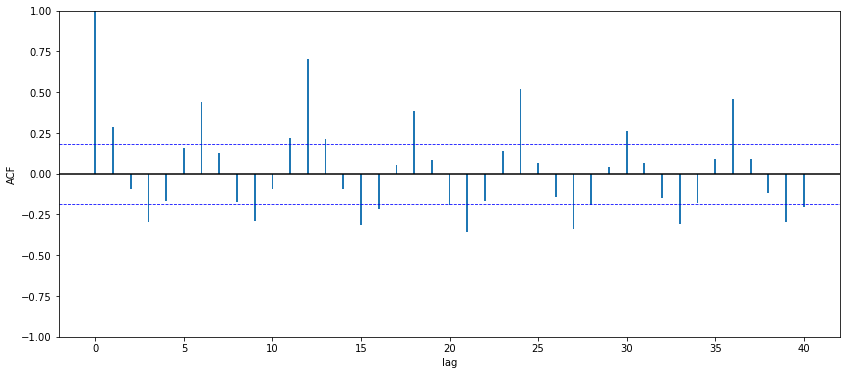

In [36]:
from statsmodels.tsa.stattools import acf, pacf
from functions import plot_sortie_acf

serie_len = len(serie) # variable nécessaire pour l'utilisation de plot_sortie_acf

plot_sortie_acf(acf(np.asarray(serie)), serie_len)

d’après l’analyse de l’autocorrélogramme  on a constaté qu’elle n’est pas stationnaire et la non stationnarité principalement liées à la saisonnalité, pour vérifier cela  on a eu recours au test de dicky fuller.

In [37]:
from statsmodels.tsa.stattools import adfuller
adfuller(serie)[1]

0.8795062928778787

La sortie ACF présente une décroissance lente vers 0  pour les multiples de 6, ce qui traduit un problème de non-stationnarité. On effectue donc une différenciation  (𝐼−𝐵6)  .

C:\Users\BOULANGER\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
C:\Users\BOULANGER\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


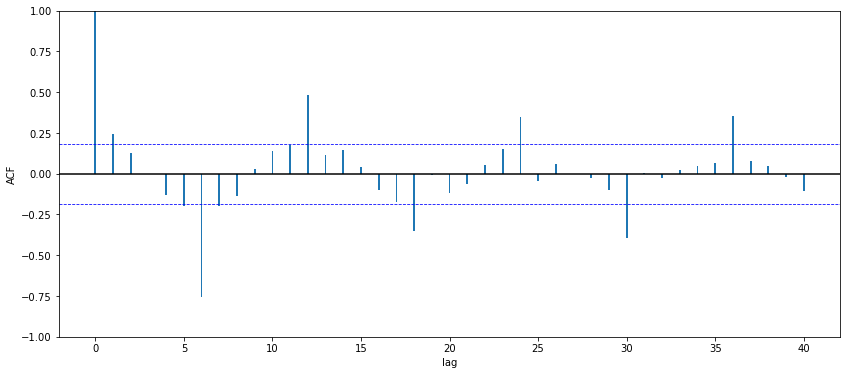

In [38]:
serie_dif1 = serie- serie.shift(6)

plot_sortie_acf(acf(np.asarray(serie_dif1[6:])),serie_len)

La sortie ACF de la série ainsi différenciée présente encore une décroissance lente vers 0 pour les multiples de 12. On effectue cette fois la différenciation  (𝐼−𝐵12)  .

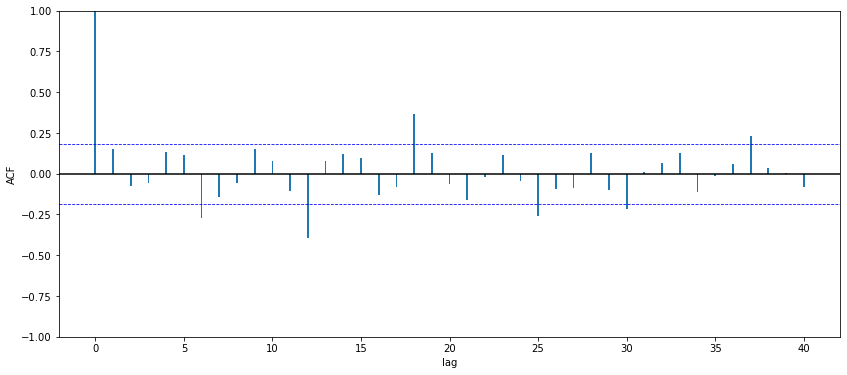

In [39]:
serie_dif_1_12 = serie_dif1 - serie_dif1.shift(12)

plot_sortie_acf(acf(np.asarray(serie_dif_1_12[18:])), serie_len)

In [40]:
adfuller(serie_dif_1_12[18:])[1]

0.04281643919058265

La sortiE ACF de la série doublement différenciée semble pouvoir être interprétée comme un autocorrélogramme simple empirique er avec le test de dicky fuller on a rassuré la statonnarité.


### Identification, estimation et validation de modèles

On utilise le librairie pmdarima qui propose la fonction auto_arima tel que elle recherche la meilleure combinaison des paramètres pour établir le modèle SARIMA .

In [85]:
import pmdarima as pm
model=pm.auto_arima(serie,m=12,seasonal=True,start_p=0,start_q=0,max_order=4,Dtest='adf', erreur_action='ignore',
                    supress_warnings=True,stepwise=True,trace=True,alpha=0.05,intercept=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=2001.252, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2064.955, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2032.803, Time=0.26 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2043.152, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2062.966, Time=0.01 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=2043.708, Time=0.17 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=2033.879, Time=0.15 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=2009.858, Time=0.77 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=2014.879, Time=0.77 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=2042.301, Time=0.14 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=2035.119, Time=0.16 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.07 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=2002.236, Time=0.45 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(1,1,1)(1,0,1)[12] inte

on vérifie la significativité des paramètres

In [73]:
model = SARIMAX(np.asarray(serie), order=(0,1,0), seasonal_order=(1,0,1,12))
results = model.fit()
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  114
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -998.486
Date:                              Mon, 25 Oct 2021   AIC                           2002.972
Time:                                      20:48:56   BIC                           2011.154
Sample:                                           0   HQIC                          2006.292
                                              - 114                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.9994      0.008    125.530      0.000       0.984       1.015
ma.S.L12      -0.98

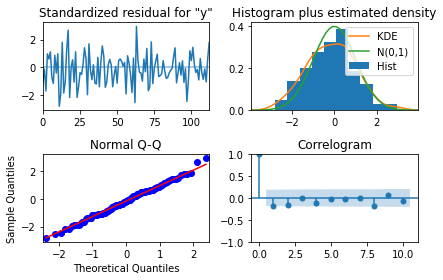

In [74]:
results.plot_diagnostics()
plt.tight_layout()
# Sauvegarde
plt.savefig("La normalité des résidus.png",dpi=80, format='png', bbox_inches="tight")
plt.show()


Le résidu est bien un bruit blanc.


on teste notre modèle tel que on n'intégre pas les 12 dernier mois de notre jeu de données afin de pouvoir  évaluer le modèle

In [75]:
model2 = SARIMAX(np.asarray(train), order=(0,1,0), seasonal_order=(1,0,1,12))
results2 = model2.fit()
print(results2.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  102
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -894.282
Date:                              Mon, 25 Oct 2021   AIC                           1794.564
Time:                                      20:49:19   BIC                           1802.409
Sample:                                           0   HQIC                          1797.740
                                              - 102                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.9501      0.061     15.593      0.000       0.831       1.070
ma.S.L12      -0.83

In [76]:
print('Retard : p-value')
for elt in [6, 12, 18, 24, 30, 36]:
    print('{} : {}'.format(elt, acorr_ljungbox(results2.resid, lags=elt)[1].mean()))

Retard : p-value
6 : 0.7769673099789342
12 : 0.8808698503903282
18 : 0.9187536799289236
24 : 0.9375788454003287
30 : 0.9498791145987221
36 : 0.9581954619667721


C:\Users\BOULANGER\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


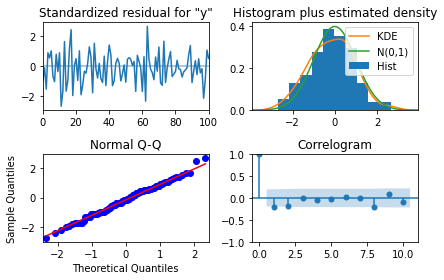

In [77]:
results2.plot_diagnostics()
plt.tight_layout()
# Sauvegarde
plt.savefig("La normalité des résidus2.png",dpi=80, format='png', bbox_inches="tight")
plt.show()# y'a pas de corrélation résidus

Les tests de significativité des paramètres et de blancheur du résidu sont validés au niveau 5%.


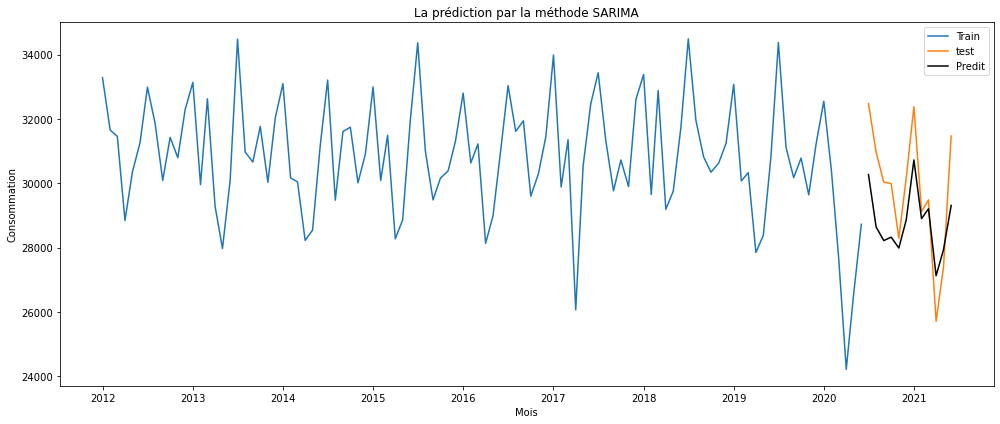

In [78]:
pred_modeltronc = results2.get_forecast(12)
pred_tronc = pred_modeltronc.predicted_mean
plt.figure(figsize=(14,6))
plt.plot(train.index,train.values, label='Train')
plt.plot(pd.date_range(train.index[len(train)-1], periods=12, freq='M'), x_a_prevoir, label='test')
plt.plot(pd.date_range(train.index[len(train)-1], periods=12, freq='M'), pred_tronc,color='k', label='Predit')
plt.legend()
plt.title('La prédiction par la méthode SARIMA')
plt.ylabel('Consommation') 
plt.xlabel('Mois') 
plt.tight_layout()
# Sauvegarde
plt.savefig("La prédiction par la méthode SARIMA.png",dpi=80, format='png', bbox_inches="tight")
plt.show()

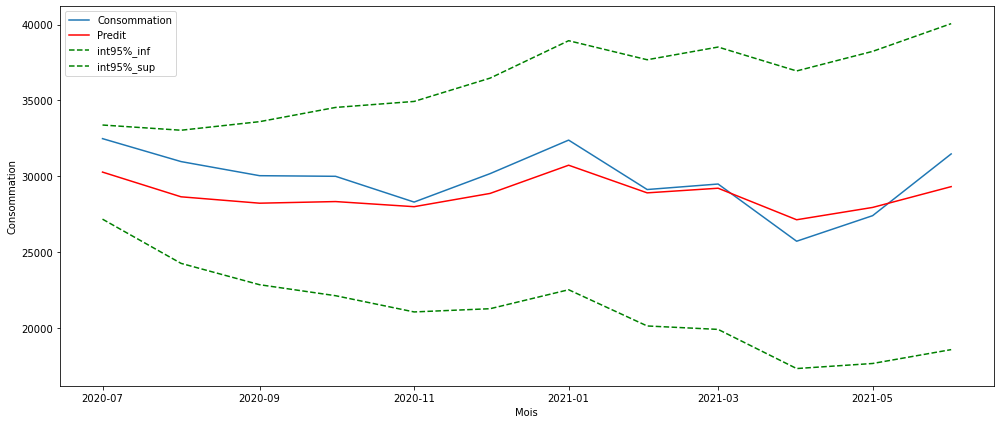

In [79]:
pred_l_tronc = pred_modeltronc.conf_int(alpha=0.05)[:,0]
pred_u_tronc = pred_modeltronc.conf_int(alpha=0.05)[:,1]
plt.figure(figsize=(14,6))
plt.plot(x_a_prevoir, label='Consommation')
plt.plot(x_a_prevoir.index, pred_tronc, color='r', label='Predit')
plt.plot(x_a_prevoir.index, pred_l_tronc, color='g', linestyle='--', label='int95%_inf')
plt.plot(x_a_prevoir.index, pred_u_tronc, color='g', linestyle='--', label='int95%_sup')
plt.legend()
plt.ylabel('Consommation') 
plt.xlabel('Mois') 
plt.tight_layout()
# Sauvegarde
plt.savefig("La prédiction SARIMA.png",dpi=80, format='png', bbox_inches="tight")

Les données prédites sont relativement fidèles aux données réelles test

In [80]:
rmse = np.sqrt(((x_a_prevoir-pred_tronc)**2).mean())
rmse

1526.3349263098573

In [81]:
mape=(np.abs(1-pred_tronc/x_a_prevoir)).mean()*100
mape

4.371229936470279

La méthode SARIMA offre des meilleurs métriques que la méthode de holt_winters.


Puis on passe à la phase de prédiction sur les 12 prochains mois (de juin 2021 à juin 2022) en appliquant le modèle obtenu via SARIMA  


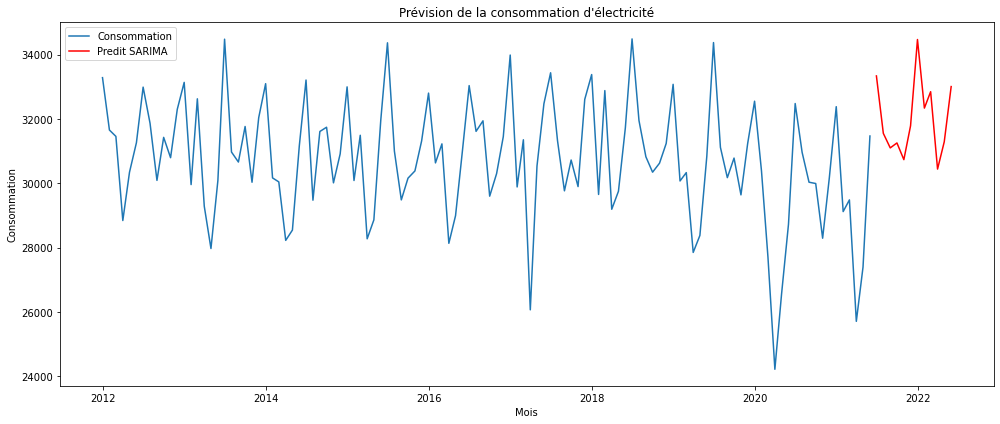

In [82]:
model1 = SARIMAX(np.asarray(serie), order=(0,1,0), seasonal_order=(1,0,1,12))
results1 = model1.fit()
pred_model=results1.get_forecast(12)
pred = pred_model.predicted_mean
plt.figure(figsize=(14,6))
plt.plot(serie, label='Consommation')
plt.plot(pd.date_range(serie.index[len(serie)-1], periods=12, freq='M'), pred, color='r', label='Predit SARIMA')
plt.legend()
plt.title("Prévision de la consommation d'électricité")
plt.ylabel('Consommation') 
plt.xlabel('Mois') 
plt.tight_layout()
# Sauvegarde
plt.savefig("Prévision de la consommation d'électricité.png",dpi=80, format='png', bbox_inches="tight")